In [2]:
import boto3
import statistics
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Read file

In [3]:
all_jobs_df = pd.read_csv('tfjobs_runs.csv')
print(len(all_jobs_df))
all_jobs_df['num_replicas_in_sync'] = all_jobs_df['num_replicas_in_sync'].astype(str)
all_jobs_df['batch_size_per_replica'] = all_jobs_df['batch_size_per_replica'].astype(str)

reduced = all_jobs_df[['device','num_replicas_in_sync','n_workers','prefetch','cache','batch_size_per_replica',
                       'average_train_time','average_test_time','nodes','gpus_per_node']]
reduced

30


,device,num_replicas_in_sync,n_workers,prefetch,cache,batch_size_per_replica,average_train_time,average_test_time,nodes,gpus_per_node
0,gpu-v100,32,4.0,no,no,96,154.29,1.74,NaN,NaN
1,gpu-v100,4,2.0,no,no,96,898.97,14.97,NaN,NaN
2,gpu-v100,2,2.0,no,no,96,1779.27,22.12,NaN,NaN
3,gpu-v100,8,2.0,no,no,96,453.05,11.25,NaN,NaN
4,gpu-v100,64,8.0,no,no,96,145.38,1.19,NaN,NaN
5,gpu-v100,16,2.0,no,no,96,227.56,6.80,NaN,NaN
6,gpu-v100,128,16.0,no,no,96,136.24,1.19,NaN,NaN
7,gpu-v100,16,2.0,yes,no,96,229.66,7.36,NaN,NaN
8,gpu-v100,2,2.0,yes,no,96,1784.42,22.40,NaN,NaN
9,gpu-v100,64,8.0,yes,no,96,59.35,1.39,NaN,NaN


## Plot n_workers

In [ ]:
batch_df = reduced.loc[(reduced['device'] == 'gpu-v100') & (reduced['num_replicas_in_sync'] == '32') & 
                      (reduced['prefetch'] == 'yes') & (reduced['batch_size_per_replica'] == '96') & 
                      (reduced['nodes'].isin([np.nan, 8, 16, 32]))]
train_times_different_nodes = sorted(list(batch_df['average_train_time']), reverse=True)
print(train_times_different_nodes)

batch_df = reduced.loc[(reduced['device'] == 'gpu-v100') & (reduced['num_replicas_in_sync'] == '32') & 
                      (reduced['prefetch'] == 'yes') & (reduced['batch_size_per_replica'] == '96') & 
                      (reduced['nodes'].isin([np.nan, '4']))]
train_times_different_4_nodes = sorted(list(batch_df['average_train_time']), reverse=True)
print(train_times_different_4_nodes)

batch_df

[1 2 3 4]
saved


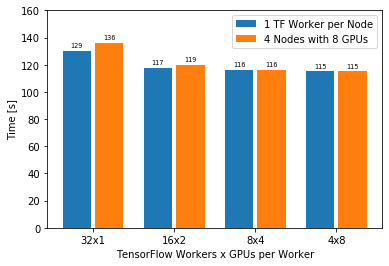

In [23]:
fig, ax = plt.subplots()
xticks = ['32x1', '16x2', '8x4', '4x8']
x = np.arange(1, len(xticks) + 1)
print(x)
rects1 = plt.bar(x - 0.2, np.array(train_times_different_nodes), width=0.35)
rects2 = plt.bar(x + 0.2, np.array(train_times_different_4_nodes), width=0.35)

plt.xticks(x, xticks)
plt.ylabel('Time [s]')
plt.xlabel('TensorFlow Workers x GPUs per Worker')
label_h_offset = 0.45

scale = 'linear'
plt.yscale(scale)

if scale == 'linear':
    plt.ylim(top=160)
    #yticks = [0, 500, 1000, 1500, 2000]
    #plt.yticks(yticks)
elif scale == 'log':
    plt.ylim(top=3000)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        if scale == 'linear':
            ax.text(rect.get_x()+rect.get_width()/2., 1*h + 2, '%d'%int(h), ha='center', va='bottom', fontsize=6.5)
        elif scale == 'log':
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h), ha='center', va='bottom', fontsize=6.5)

autolabel(rects1)
autolabel(rects2)

plt.legend(['1 TF Worker per Node', '4 Nodes with 8 GPUs'])

plt.savefig('results/tfjobs_compare_hw_layout_' + scale + '.png', dpi=150)
print('saved')
plt.show()

## Plot batch size

In [17]:
batch_df = reduced.loc[(reduced['device'] == 'gpu-v100') & (reduced['num_replicas_in_sync'] == '32') & 
                      (reduced['prefetch'] == 'yes') & (reduced['n_workers'] == 4.0) & \
                       (reduced['batch_size_per_replica'].isin(['96','80','64','48','32','16']))]
train_times_batch_size = sorted(list(batch_df['average_train_time']), reverse=True)
print(train_times_batch_size)

batch_df

[182.65, 142.23, 128.19, 121.69, 120.11, 115.02]


,device,num_replicas_in_sync,n_workers,prefetch,cache,batch_size_per_replica,average_train_time,average_test_time,nodes,gpus_per_node
13,gpu-v100,32,4.0,yes,no,96,115.02,3.37,NaN,NaN
18,gpu-v100,32,4.0,yes,no,48,128.19,6.00,NaN,NaN
19,gpu-v100,32,4.0,yes,no,32,142.23,6.20,NaN,NaN
20,gpu-v100,32,4.0,yes,no,80,120.11,3.22,NaN,NaN
21,gpu-v100,32,4.0,yes,no,16,182.65,7.24,NaN,NaN
22,gpu-v100,32,4.0,yes,no,64,121.69,5.21,NaN,NaN


[1 2 3 4 5 6]
saved


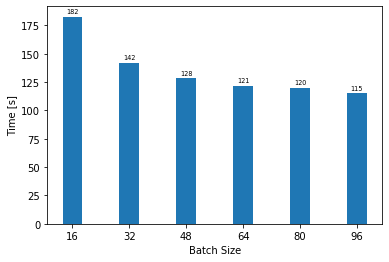

In [21]:
fig, ax = plt.subplots()
xticks = ['16', '32', '48', '64', '80', '96']
x = np.arange(1, len(xticks) + 1)
print(x)
rects1 = plt.bar(x, np.array(train_times_batch_size), width=0.35)

plt.xticks(x, xticks)
plt.ylabel('Time [s]')
plt.xlabel('Batch Size')
label_h_offset = 0.45

scale = 'linear'
plt.yscale(scale)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        if scale == 'linear':
            ax.text(rect.get_x()+rect.get_width()/2., 1*h + 2, '%d'%int(h), ha='center', va='bottom', fontsize=6.5)
        elif scale == 'log':
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h), ha='center', va='bottom', fontsize=6.5)

autolabel(rects1)

plt.savefig('results/tfjobs_compare_batch_size_' + scale + '.png', dpi=150)
print('saved')
plt.show()

## Plot n_gpus_scaling

In [29]:
batch_df = reduced.loc[(reduced['device'] == 'gpu-v100') & \
                       (reduced['num_replicas_in_sync'].isin(['2','4','8','16','32','64','128'])) & 
                      (reduced['prefetch'] == 'yes') & (reduced.index < 23) & \
                       (reduced['batch_size_per_replica'].isin(['96']))]
train_times_scaling = sorted(list(batch_df['average_train_time']), reverse=True)
print(train_times_scaling)

batch_df

[1784.42, 900.49, 456.62, 229.66, 115.02, 59.35, 34.9]


,device,num_replicas_in_sync,n_workers,prefetch,cache,batch_size_per_replica,average_train_time,average_test_time,nodes,gpus_per_node
7,gpu-v100,16,2.0,yes,no,96,229.66,7.36,NaN,NaN
8,gpu-v100,2,2.0,yes,no,96,1784.42,22.40,NaN,NaN
9,gpu-v100,64,8.0,yes,no,96,59.35,1.39,NaN,NaN
10,gpu-v100,4,2.0,yes,no,96,900.49,11.40,NaN,NaN
11,gpu-v100,8,2.0,yes,no,96,456.62,8.05,NaN,NaN
12,gpu-v100,128,16.0,yes,no,96,34.90,1.64,NaN,NaN
13,gpu-v100,32,4.0,yes,no,96,115.02,3.37,NaN,NaN


[1 2 3 4 5 6 7]
saved


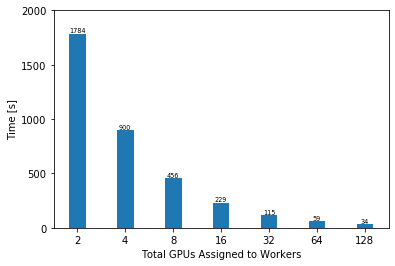

In [43]:
fig, ax = plt.subplots()
xticks = ['2','4','8','16','32','64','128']
x = np.arange(1, len(xticks) + 1)
print(x)
rects1 = plt.bar(x, np.array(train_times_scaling), width=0.35)

plt.xticks(x, xticks)
plt.ylabel('Time [s]')
plt.xlabel('Total GPUs Assigned to Workers')
label_h_offset = 0.45

scale = 'linear'
plt.yscale(scale)

if scale == 'linear':
    plt.ylim(top=2000)
    yticks = [0, 500, 1000, 1500, 2000]
    plt.yticks(yticks)
elif scale == 'log':
    from matplotlib.ticker import ScalarFormatter
    ax.yaxis.set_major_formatter(ScalarFormatter())
    yticks = [10, 100, 1000]
    plt.yticks(yticks)
    plt.ylim(top=2300) 

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        if scale == 'linear':
            ax.text(rect.get_x()+rect.get_width()/2., 1*h + 2, '%d'%int(h), ha='center', va='bottom', fontsize=6.5)
        elif scale == 'log':
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h), ha='center', va='bottom', fontsize=6.5)

autolabel(rects1)

plt.savefig('results/tfjobs_compare_n_gpus_scaling_' + scale + '.png', dpi=150)
print('saved')
plt.show()

## Plot metrics history

In [ ]:
def get_metrics_for_all_epochs(df, metrics):
    columns = [x for x in df.columns if metrics in x]
    filtered_df = df[columns]
    return filtered_df
    
filtered_df = get_metrics_for_all_epochs(all_jobs_df, 'discriminator_train_binary_loss')

row = list(filtered_df.iloc[21].astype(float))
print(row)
plt.plot(row)
plt.show()
filtered_df